# SOK-1005 V25
## Arbeidskrav 4
Kandidatnr: 41.

I denne undersøkelsen hentet vi data om elbiler fra Motor.no for å se hvorvidt WLTP-tall samsvarer med faktisk rekkevidde under vinterforhold. Etter rensing av datasettet og oppretting av en kolonne som viser forholdet mellom levert og påstått kilometer, beregnet vi et «avvik» for hver bil. 

Ved å plotte regresjonslinjen mot de faktiske dataene, både med og uten origo, så vi hvordan y-aksen kan manipuleres til å overdrive eller dempe synlige forskjeller. Selv om mange biler ligger nær den lovede rekkevidden, har noen merkbart kortere enn WLTP-tallene. 

Den gjennomsnittlige differansen er et visst antall kilometer under produsentenes påstand, og konklusjonen om hvorvidt de «holder det de lover» avhenger av hva man anser som akseptabelt avvik.


DataFrame etter rensing og ny kolonne for forhold:
                         Modell WLTP_tall (km/kWh) STOPP (km) Avvik_str  \
0   Tesla Model 3 LR Dual motor    614 km/14,7 kWh     521 km  -15,15 %   
1  Mercedes-Benz EQS 580 4matic    645 km/18,3 kWh     513 km  -20,47 %   
2               BMW iX xDrive50    591 km/21,4 kWh     503 km  -14,89 %   
3   Tesla Model Y LR Dual motor    507 km/16,9 kWh     451 km  -11,05 %   
4         Volkswagen ID.3 PRO S    539 km/16,3 kWh     435 km  -19,29 %   

  WLTP_km_str WLTP_kWh_str  WLTP_km  WLTP_kWh  Levert_km  Forhold_Levert_WLTP  
0         614         14.7      614      14.7      521.0             0.848534  
1         645         18.3      645      18.3      513.0             0.795349  
2         591         21.4      591      21.4      503.0             0.851100  
3         507         16.9      507      16.9      451.0             0.889546  
4         539         16.3      539      16.3      435.0             0.807050  

Regresjonsresult

C:\Users\andre\AppData\Local\Temp\ipykernel_30248\2136222778.py:23: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html))[0]


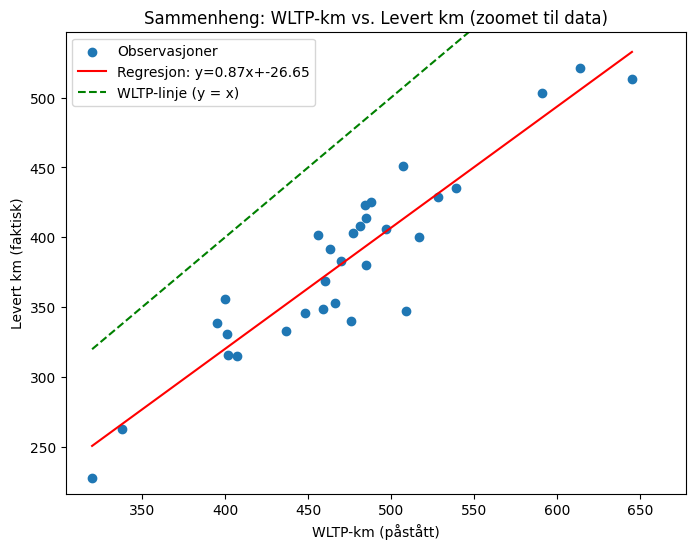

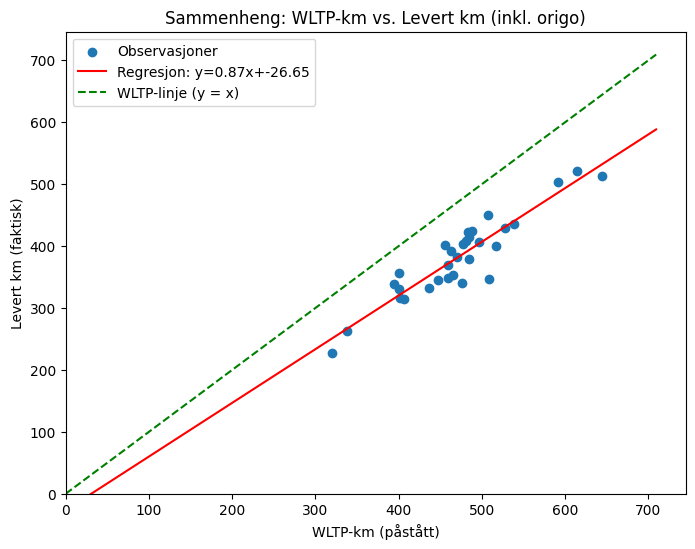

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def fetch_html_tables(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    tables = soup.find_all("table")
    return tables

url = "https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132"
tables = fetch_html_tables(url)

if not tables:
    print("Fant ingen tabeller på siden.")
    exit()

# Velger den første tabellen
table_html = tables[0]
df = pd.read_html(str(table_html))[0]

# Gir kolonnene mer håndterlige navn
df.columns = ["Modell", "WLTP_tall (km/kWh)", "STOPP (km)", "Avvik_str"]

# Splitter WLTP-tall (km/kWh) i to kolonner: WLTP_km og WLTP_kWh
df[["WLTP_km_str", "WLTP_kWh_str"]] = df["WLTP_tall (km/kWh)"].str.extract(
    r"(\d+)\s*km/\s*(\d+[.,]\d+)\s*kWh"
)
df["WLTP_kWh_str"] = df["WLTP_kWh_str"].str.replace(",", ".", regex=True)
df["WLTP_km"]  = pd.to_numeric(df["WLTP_km_str"],  errors='coerce')
df["WLTP_kWh"] = pd.to_numeric(df["WLTP_kWh_str"], errors='coerce')

# Ta ut Levert_km fra "STOPP (km)"
df["Levert_km"] = (
    df["STOPP (km)"]
    .str.extract(r"(\d+)")
    .astype(float)
)

# Fjerner rader med manglende verdier
df.dropna(subset=["WLTP_km", "WLTP_kWh", "Levert_km"], inplace=True)

# Kolonne for forholdet (Levert km / WLTP km)
df["Forhold_Levert_WLTP"] = df["Levert_km"] / df["WLTP_km"]

print("\nDataFrame etter rensing og ny kolonne for forhold:")
print(df.head())

# Lage en regresjonsmodell: f(x) = a*x + b, der x = WLTP_km
reg_result = linregress(df["WLTP_km"], df["Levert_km"])
a = reg_result.slope
b = reg_result.intercept
r_value = reg_result.rvalue
p_value = reg_result.pvalue

print("\nRegresjonsresultat:")
print(f"a (stigningstall) = {a:.4f}")
print(f"b (intercept)     = {b:.4f}")
print(f"R^2               = {r_value**2:.4f}")
print(f"p-verdi           = {p_value:.4g}")

# Plott datapunktene i to varianter
# Felles klargjøring:
x_vals = np.linspace(df["WLTP_km"].min(), df["WLTP_km"].max(), 100)
y_vals = a * x_vals + b

plt.figure(figsize=(8,6))
plt.scatter(df["WLTP_km"], df["Levert_km"], label="Observasjoner")

# Regresjonslinje
plt.plot(x_vals, y_vals, color="red", label=f"Regresjon: y={a:.2f}x+{b:.2f}")

# Referanselinje (y = x) for å vise leverandørens påståtte kjørelenge
plt.plot(x_vals, x_vals, color="green", label="WLTP-linje (y = x)", linestyle="--")

plt.xlabel("WLTP-km (påstått)")
plt.ylabel("Levert km (faktisk)")
plt.title("Sammenheng: WLTP-km vs. Levert km (zoomet til data)")
plt.xlim(df["WLTP_km"].min() * 0.95, df["WLTP_km"].max() * 1.05)
plt.ylim(df["Levert_km"].min() * 0.95, df["Levert_km"].max() * 1.05)
plt.legend()
plt.show()

# Plot som inkluderer origo
plt.figure(figsize=(8,6))
plt.scatter(df["WLTP_km"], df["Levert_km"], label="Observasjoner")

# Regresjonslinje
x_vals_full = np.linspace(0, df["WLTP_km"].max() * 1.1, 100)
y_vals_full = a * x_vals_full + b
plt.plot(x_vals_full, y_vals_full, color="red", label=f"Regresjon: y={a:.2f}x+{b:.2f}")

# WLTP-linje
plt.plot(x_vals_full, x_vals_full, color="green", label="WLTP-linje (y = x)", linestyle="--")

plt.xlabel("WLTP-km (påstått)")
plt.ylabel("Levert km (faktisk)")
plt.title("Sammenheng: WLTP-km vs. Levert km (inkl. origo)")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.show()

Jeg har brukt ChatGPT til å lage, rydde og fikse kode. Samt oppsummere og rydde i deler av teksten.
Har også brukt tidligere forelesninger som kilder til koding og webskraping. 

https://github.com/Sjeroks/SOK-1005-V25-Assignments